In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu, enable=True)   
#GPU内存管理

In [3]:
train_dir = 'sat2/train'
test_dir = 'sat2/val'

im_size = 224
batch_size = 32

In [4]:
train_images = ImageDataGenerator(rescale = 1/255,horizontal_flip=True)
test_images = ImageDataGenerator(rescale = 1/255)
#归一化

In [5]:
train_gen = train_images.flow_from_directory(directory=train_dir,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             target_size=(im_size, im_size),
                                             class_mode='categorical')
#按路径载入图片，批处理大小，随机，尺寸，读热编码

Found 3150 images belonging to 5 classes.


In [6]:
val_gen = test_images.flow_from_directory(directory=test_dir,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          target_size=(im_size, im_size),
                                          class_mode='categorical')
#按路径载入图片，批处理大小，随机，尺寸，读热编码

Found 350 images belonging to 5 classes.


In [7]:
def BasicBlock(filter_num, strides, _inputs):

    x = tf.keras.layers.Conv2D(filters=filter_num, kernel_size=3, strides=strides, padding='same')(_inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filter_num, kernel_size=3, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
        
    if strides != 1:
        y = tf.keras.layers.Conv2D(filters=filter_num,kernel_size=1,strides=strides)(_inputs)
        y = tf.keras.layers.BatchNormalization()(y)
    else:
        y = _inputs
        
    output = tf.keras.layers.add([x, y])
    output = tf.keras.layers.Activation('relu')(output)
    
    return output

#resnet 18 34 

In [8]:
def ResNet18(): #2 2 2 2
    input_image = tf.keras.layers.Input(shape=(224, 224, 3))
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2,padding="same")(input_image)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding="same")(x)
    
    x = BasicBlock(64,strides=1,_inputs=x)
    x = BasicBlock(64,strides=1,_inputs=x)
    
    x = BasicBlock(128,strides=2,_inputs=x)
    x = BasicBlock(128,strides=1,_inputs=x)
    
    x = BasicBlock(256,strides=2,_inputs=x)
    x = BasicBlock(256,strides=1,_inputs=x)
    
    x = BasicBlock(512,strides=2,_inputs=x)
    x = BasicBlock(512,strides=1,_inputs=x)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(5, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=input_image, outputs=x)
    return model

In [9]:
def BottleNeck(filter_num,strides,_inputs, down=False):

    x = tf.keras.layers.Conv2D(filters=filter_num,kernel_size=1,strides=1,padding='same')(_inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters=filter_num,kernel_size=3,strides=strides,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters=filter_num * 4,kernel_size=1,strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if strides != 1 or down==True:
        y = tf.keras.layers.Conv2D(filters=filter_num* 4,kernel_size=1,strides=strides)(_inputs)
        y = tf.keras.layers.BatchNormalization()(y)
    else:
        y = _inputs
    
    output = tf.keras.layers.add([x, y])
    output = tf.keras.layers.Activation('relu')(output)

    return output
#resnet 50 101 152

In [10]:
def ResNet50():# 3 4 6 3
    input_image = tf.keras.layers.Input(shape=(224, 224, 3))
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding="same")(input_image)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding="same")(x)

    x = BottleNeck(filter_num=64,strides=1,_inputs=x,down=True)
    x = BottleNeck(filter_num=64,strides=1,_inputs=x)    
    x = BottleNeck(filter_num=64,strides=1,_inputs=x)
    
    x = BottleNeck(filter_num=128,strides=2,_inputs=x)
    x = BottleNeck(filter_num=128,strides=1,_inputs=x)
    x = BottleNeck(filter_num=128,strides=1,_inputs=x)
    x = BottleNeck(filter_num=128,strides=1,_inputs=x)  
    
    x = BottleNeck(filter_num=256,strides=2,_inputs=x)
    x = BottleNeck(filter_num=256,strides=1,_inputs=x)    
    x = BottleNeck(filter_num=256,strides=1,_inputs=x)
    x = BottleNeck(filter_num=256,strides=1,_inputs=x)
    x = BottleNeck(filter_num=256,strides=1,_inputs=x)    
    x = BottleNeck(filter_num=256,strides=1,_inputs=x)    
    
    x = BottleNeck(filter_num=512,strides=2,_inputs=x)
    x = BottleNeck(filter_num=512,strides=1,_inputs=x)    
    x = BottleNeck(filter_num=512,strides=1,_inputs=x)    
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(5, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=input_image, outputs=x)
    return model

In [11]:
# model = ResNet50()
model = ResNet18()

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['acc'])
#学习率设置

In [14]:
history = model.fit(train_gen,epochs=10,validation_data=val_gen)

Epoch 1/10
99/99 [==============================] - 9s 55ms/step - loss: 1.5499 - acc: 0.4992 - val_loss: 4.8414 - val_acc: 0.2114
Epoch 2/10
99/99 [==============================] - 5s 46ms/step - loss: 0.8033 - acc: 0.6757 - val_loss: 6.9027 - val_acc: 0.2029
Epoch 3/10
99/99 [==============================] - 5s 46ms/step - loss: 0.6492 - acc: 0.7679 - val_loss: 2.4262 - val_acc: 0.3514
Epoch 4/10
99/99 [==============================] - 5s 47ms/step - loss: 0.6354 - acc: 0.7727 - val_loss: 4.4309 - val_acc: 0.3771
Epoch 5/10
99/99 [==============================] - 5s 47ms/step - loss: 0.5862 - acc: 0.7942 - val_loss: 1.7271 - val_acc: 0.4600
Epoch 6/10
99/99 [==============================] - 5s 46ms/step - loss: 0.4529 - acc: 0.8403 - val_loss: 0.8259 - val_acc: 0.7686
Epoch 7/10
99/99 [==============================] - 5s 46ms/step - loss: 0.3977 - acc: 0.8614 - val_loss: 1.5415 - val_acc: 0.6229
Epoch 8/10
99/99 [==============================] - 5s 46ms/step - loss: 0.3808 - a

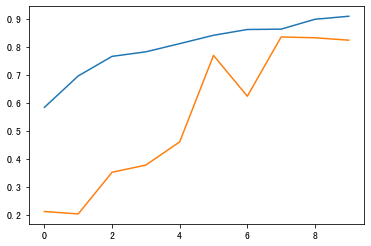

In [15]:
plt.plot(history.epoch,history.history.get('acc'))
plt.plot(history.epoch,history.history.get('val_acc'))

In [16]:
model.evaluate(val_gen)

11/11 [==============================] - 0s 37ms/step - loss: 0.5305 - acc: 0.8229


[0.5305225253105164, 0.822857141494751]

In [17]:
# 保存模型
model.save('sat928.h5')